In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
import math
from histogram_medians import bin_medians
from d_index_v2 import Agent, total_voting_power, get_leading_sets, calc_NashEquilibrium_Pagreement

# Decentralization metrics functions
def gini_coefficient(x):
    x = np.sort(x)
    n = x.shape[0]
    cumulative_values = np.cumsum(x, dtype=float)
    relative_mean_difference = np.sum(cumulative_values) / cumulative_values[-1]
    gini_index = (n + 1 - 2 * relative_mean_difference) / n
    return gini_index

def herfindahl_hirschman_index(x):
    x = np.array(x)
    share = x / np.sum(x)
    hhi = np.sum(share ** 2)
    return hhi

def distribution_entropy(x):
    x = np.array(x)
    # Check if the sum of x is zero, return 0 for invalid distributions
    if np.sum(x) == 0:
        return 0  # or another meaningful value
    # Normalize the array to probabilities
    probabilities = x / np.sum(x)
    # Calculate entropy using scipy
    return entropy(probabilities, base=None) 

def calc_t_Paggreement(distribution,bins):
    if len(distribution) > bins:
        sample = bin_medians(distribution,bins)
        print(len(sample))
        agents = [Agent(i + 1, num) for i, num in enumerate(sample)]
        vpthres = total_voting_power(agents) / 2.0
        vpthres = vpthres + 1 if vpthres.is_integer() else math.ceil(vpthres)
        ret = get_leading_sets(agents, vpthres, 0)
        
        t_Paggreement = 0
        for s in ret:
            t_Paggreement += calc_NashEquilibrium_Pagreement(s)
        
        return t_Paggreement / len(ret)
    else:
        agents = [Agent(i + 1, num) for i, num in enumerate(distribution)]
        vpthres = total_voting_power(agents) / 2.0
        vpthres = vpthres + 1 if vpthres.is_integer() else math.ceil(vpthres)
        ret = get_leading_sets(agents, vpthres, 0)
        
        t_Paggreement = 0
        for s in ret:
            t_Paggreement += calc_NashEquilibrium_Pagreement(s)
        
        return t_Paggreement / len(ret)
    
def calc_nakamoto_coefficient(distribution):
    sorted_dist = sorted(distribution, reverse=True)
    cumulative_sum = np.cumsum(sorted_dist)
    total_sum = cumulative_sum[-1]
    for i, value in enumerate(cumulative_sum):
        if value > total_sum / 2:
            return i + 1
    return len(distribution)

# Function to apply metrics and store results
def apply_metrics(distribution, name, sample_length, bins = 17):
    gini = gini_coefficient(distribution)
    hhi = herfindahl_hirschman_index(distribution)
    ent = distribution_entropy(distribution)
    t_Pag = calc_t_Paggreement(distribution, bins)
    nakamoto = calc_nakamoto_coefficient(distribution)
    
    results = {
        "Distribution": name,
        "Sample Length": sample_length,
        "Gini Coefficient": gini,
        "Herfindahl-Hirschman Index": hhi,
        "Entropy": ent,
        "Nakamoto Coefficient": nakamoto,
        "Apokedro": t_Pag
    }
    return results

# Initialize results list
all_results = []


In [5]:
import pandas as pd
# Load CSV files
token_holders_path = "/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/data_miner/compound_token_holders.csv"
delegates_path = "/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/data_miner/compound_delegates.csv"

token_holders_df = pd.read_csv(token_holders_path)
delegates_df = pd.read_csv(delegates_path)

# Apply metrics to token holders
token_holders_metrics = apply_metrics(
    token_holders_df['balance_in_comp'].values,
    name="Token Holders",
    sample_length=len(token_holders_df),
    bins=28
)

# Apply metrics to delegates
delegates_metrics = apply_metrics(
    delegates_df['balance'].values,
    name="Delegates",
    sample_length=len(delegates_df),
    bins=28
)

# Combine results into a DataFrame
all_metrics = [token_holders_metrics, delegates_metrics]
results_df = pd.DataFrame(all_metrics)

# Save results to a CSV file
output_path = "coump_decentralization_metrics_results.csv"
results_df.to_csv(output_path, index=False)

print(f"Metrics have been calculated and saved to {output_path}")

9
9
Metrics have been calculated and saved to coump_decentralization_metrics_results.csv


In [8]:
import pandas as pd
from pathlib import Path

# Define the path where proposal files are stored
votes_path = Path("/Users/manos/Documents/Code/COMP Decentralization/Data/Votes")

# Placeholder for all results
proposal_metrics = []

# Loop through all proposal files (001.xlsx to 082.xlsx)
for i in range(1, 83):  # Proposal numbers from 001 to 082
    file_name = f"{i:03}.xlsx"  # Format: 001.xlsx, 002.xlsx, ..., 082.xlsx
    file_path = votes_path / file_name

    # Check if file exists
    if file_path.exists():
        # Read the voter balance data from the file
        try:
            # Read the Excel file
            df = pd.read_excel(file_path)

            # Convert "for_votes" and "against_votes" columns to numeric
            if "for_votes" in df.columns and "against" in df.columns:
                df["for_votes"] = pd.to_numeric(df["for_votes"], errors="coerce")
                df["against_votes"] = pd.to_numeric(df["against"], errors="coerce")

                # Combine the distributions for the calculation
                combined_distribution = pd.concat([df["for_votes"], df["against_votes"]]).dropna().values

                # Calculate metrics for this proposal
                metrics = apply_metrics(
                    combined_distribution,
                    name=f"Proposal {i:03}",
                    sample_length=len(combined_distribution),
                    bins=28
                )
                proposal_metrics.append(metrics)
            else:
                print(f"Columns 'for_votes' or 'against' not found in {file_name}. Skipping...")
        except Exception as e:
            print(f"Error processing {file_name}: {e}")
    else:
        print(f"File {file_name} not found. Skipping...")

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(proposal_metrics)

# Calculate average metrics across all proposals
average_metrics = metrics_df.mean(numeric_only=True)
average_metrics["Distribution"] = "Average"
average_metrics["Sample Length"] = "N/A"
metrics_df = pd.concat([metrics_df, pd.DataFrame([average_metrics])], ignore_index=True)

# Save results to a CSV file
output_path = "comp_proposal_decentralization_metrics_combined.csv"
metrics_df.to_csv(output_path, index=False)

print(f"Metrics for all proposals and their averages have been saved to {output_path}")

6
5
6
12
3
2
9
10
9
8
4
9
7
8
6
7
11
9
8
10
7
8
6
6
9
9
8
9
7
5
8
7
7
6
5
6
6
6
Error processing 048.xlsx: index -1 is out of bounds for axis 0 with size 0
5
6
6
6
8
Error processing 055.xlsx: index -1 is out of bounds for axis 0 with size 0
9
8
Error processing 075.xlsx: index -1 is out of bounds for axis 0 with size 0
Error processing 080.xlsx: index -1 is out of bounds for axis 0 with size 0
Metrics for all proposals and their averages have been saved to comp_proposal_decentralization_metrics_combined.csv


In [3]:
# Sample lengths to test
sample_lengths = list(range(2, 1000)) + list(range(1000, 30000, 100))

# Distributions to test
distributions = {
    "Uniform": lambda n: np.random.uniform(1, 10, n),
    "Normal": lambda n: np.random.normal(50, 10, n),
    "Exponential": lambda n: np.random.exponential(50, n),
    "Bimodal": lambda n: np.concatenate([np.random.normal(30, 5, n//2), np.random.normal(70, 5, n//2)]),
    "Log-normal": lambda n: np.random.lognormal(1, 0.5, n),
    "Chi-Square": lambda n: np.random.chisquare(2, n)
}

# Run experiment and record results
problematic_sample = None  # Initialize variable to store problematic sample if found

for length in sample_lengths:
    for name, dist_func in distributions.items():
        distribution = dist_func(length)
        results = apply_metrics(distribution, name, length)
        
        # Check for -inf in entropy and stop the loop if found
        if results["Entropy"] == float('-inf'):
            problematic_sample = {
                "Distribution": name,
                "Sample Length": length,
                "Sample Data": distribution,
                "Results": results
            }
            print(f"Found -inf entropy in {name} distribution with sample length {length}. Stopping...")
            break  # Stop iteration if problematic sample is found
        
        all_results.append(results)
        print(f"Processed {name} distribution with sample length {length}")
    
    if problematic_sample:
        break  # Exit the outer loop if -inf entropy is encountered

# Output the problematic sample for inspection
if problematic_sample:
    print("\n--- Problematic Sample ---")
    print(f"Distribution: {problematic_sample['Distribution']}")
    print(f"Sample Length: {problematic_sample['Sample Length']}")
    print(f"Entropy: {problematic_sample['Results']['Entropy']}")
    print(f"Sample Data (first 10 values): {problematic_sample['Sample Data'][:10]}")
else:
    print("No -inf entropy found.")

Processed Uniform distribution with sample length 2
Processed Normal distribution with sample length 2
Processed Exponential distribution with sample length 2
Processed Bimodal distribution with sample length 2
Processed Log-normal distribution with sample length 2
Processed Chi-Square distribution with sample length 2
Processed Uniform distribution with sample length 3
Processed Normal distribution with sample length 3
Processed Exponential distribution with sample length 3
Processed Bimodal distribution with sample length 3
Processed Log-normal distribution with sample length 3
Processed Chi-Square distribution with sample length 3
Processed Uniform distribution with sample length 4
Processed Normal distribution with sample length 4
Processed Exponential distribution with sample length 4
Processed Bimodal distribution with sample length 4
Processed Log-normal distribution with sample length 4
Processed Chi-Square distribution with sample length 4
Processed Uniform distribution with s

KeyboardInterrupt: 

In [2]:
# Sample lengths to test
sample_lengths = list(range(2, 1000)) + list(range(1000,30000,100)) #[25, 30, 50, 80, 100, 250, 500, 1000, 3000, 5000, 10000, 20000]

# Distributions to test
distributions = {
    "Uniform": lambda n: np.random.uniform(1, 10, n),
    "Normal": lambda n: np.random.normal(50, 10, n),
    "Exponential": lambda n: np.random.exponential(50, n),
    "Bimodal": lambda n: np.concatenate([np.random.normal(30, 5, n//2), np.random.normal(70, 5, n//2)]),
    "Log-normal": lambda n: np.random.lognormal(1, 0.5, n),
    "Chi-Square": lambda n: np.random.chisquare(2, n)
}

# Run experiment and record results
for length in sample_lengths:
    for name, dist_func in distributions.items():
        distribution = dist_func(length)
        results = apply_metrics(distribution, name, length)
        all_results.append(results)
        print(f"Processed {name} distribution with sample length {length}")



Processed Uniform distribution with sample length 2
Processed Normal distribution with sample length 2
Processed Exponential distribution with sample length 2
Processed Bimodal distribution with sample length 2
Processed Log-normal distribution with sample length 2
Processed Chi-Square distribution with sample length 2
Processed Uniform distribution with sample length 3
Processed Normal distribution with sample length 3
Processed Exponential distribution with sample length 3
Processed Bimodal distribution with sample length 3
Processed Log-normal distribution with sample length 3
Processed Chi-Square distribution with sample length 3
Processed Uniform distribution with sample length 4
Processed Normal distribution with sample length 4
Processed Exponential distribution with sample length 4
Processed Bimodal distribution with sample length 4
Processed Log-normal distribution with sample length 4
Processed Chi-Square distribution with sample length 4
Processed Uniform distribution with s

In [3]:
import pandas as pd

# Create DataFrame from results
results_df = pd.DataFrame(all_results)

# Save results to a CSV file
results_df.to_csv('experiment_results_4.csv', index=False)

# Display summary of results
results_df


Distribution  Sample Length  Gini Coefficient  \
0         Uniform              2          0.126152   
1          Normal              2          0.033735   
2     Exponential              2          0.465841   
3         Bimodal              2          0.174749   
4      Log-normal              2          0.123858   
...           ...            ...               ...   
7723       Normal          29900          0.112897   
7724  Exponential          29900          0.500867   
7725      Bimodal          29900          0.228269   
7726   Log-normal          29900          0.278555   
7727   Chi-Square          29900          0.500814   

      Herfindahl-Hirschman Index    Entropy  Nakamoto Coefficient  Apokedro  
0                       0.531829   0.660972                     1  1.000000  
1                       0.502276   0.690869                     1  1.000000  
2                       0.934016   0.148915                     1  1.000000  
3                       0.561074   0.630765                     1  1.000000  
4                       0.530681   0.662144                     1  0.500000  
...                          ...        ...                   ...       ...  
7723                    0.000035  10.285199                 12608  0.006572  
7724                    0.000067   9.880980                  5557  0.013882  
7725                    0.000039  10.217231                 10301  0.006270  
7726                    0.000043  10.178704                  9176  0.008133  
7727                    0.000067   9.881718                  5591  0.033999  

[7728 rows x 7 columns]

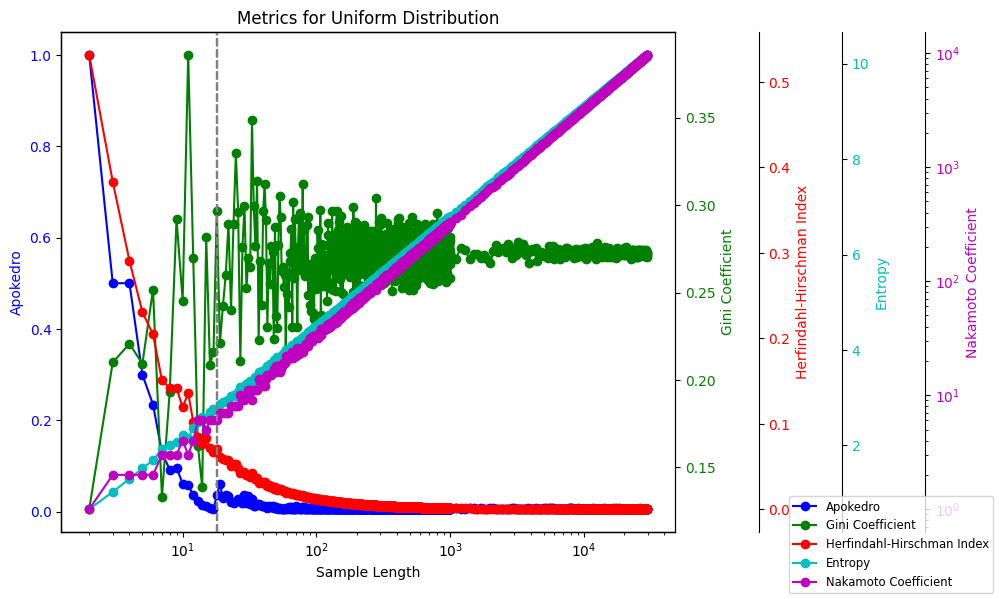

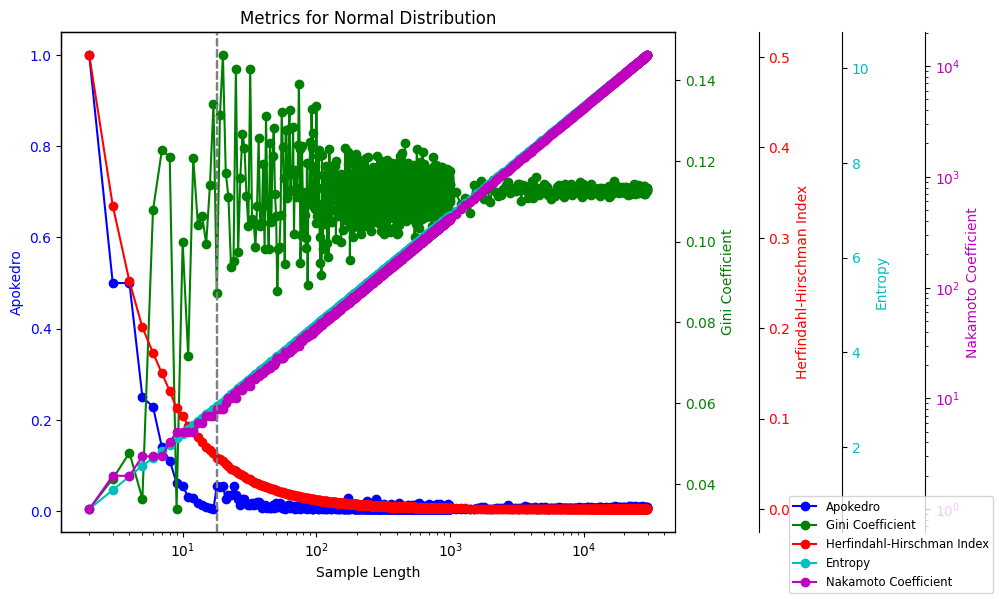

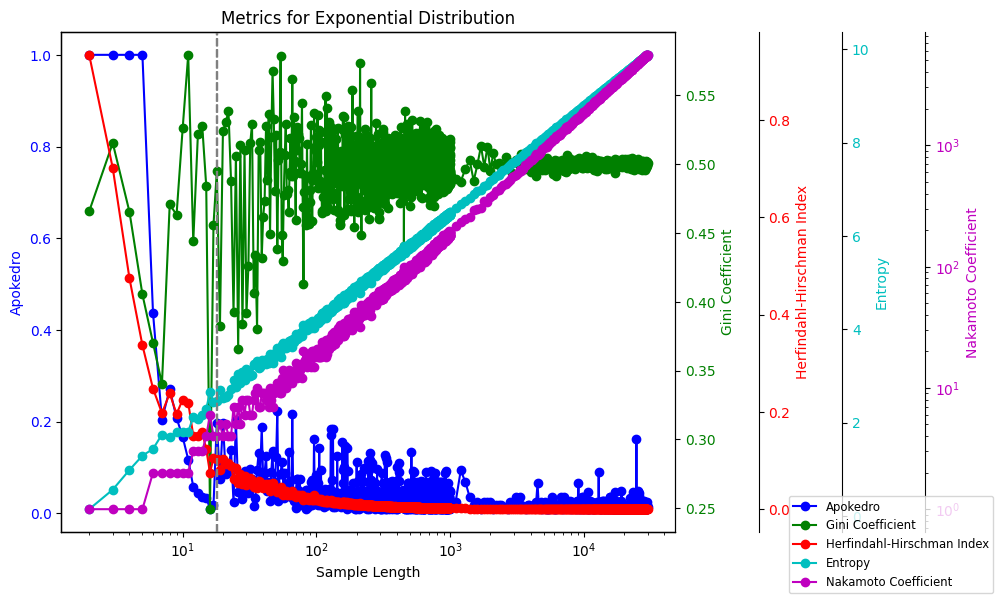

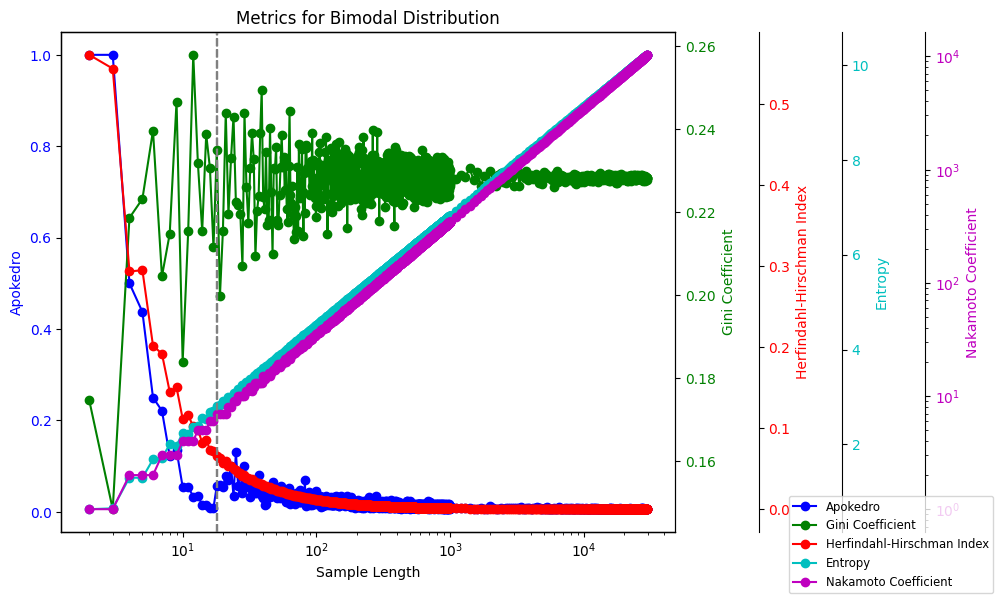

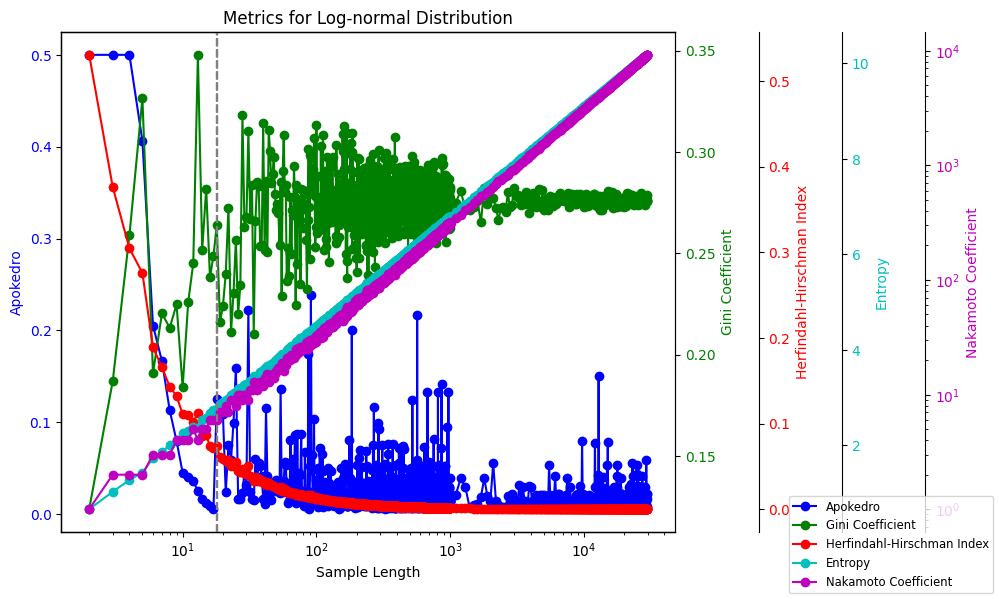

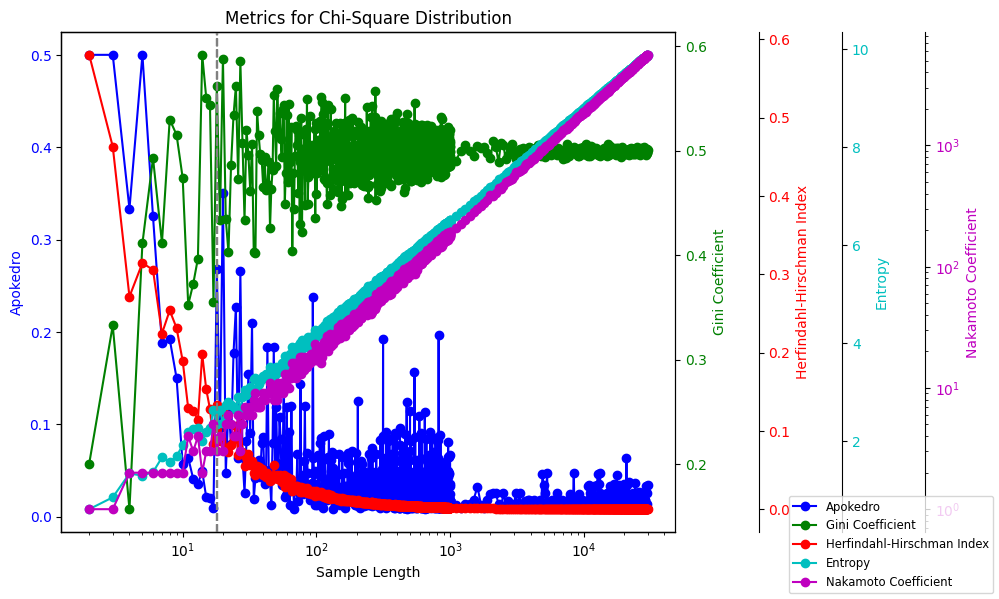

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_df is already available with the necessary data

# Metrics to plot, with Apokedro first
metrics = ["Apokedro", "Gini Coefficient", "Herfindahl-Hirschman Index", "Entropy", "Nakamoto Coefficient"]
colors = ['b', 'g', 'r', 'c', 'm']

# Plotting
for name in results_df["Distribution"].unique():
    dist_data = results_df[results_df["Distribution"] == name]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Primary axis for Apokedro
    lines = []
    labels = []
    line, = ax1.plot(dist_data["Sample Length"], dist_data["Apokedro"], marker='o', linestyle='-', color=colors[0], label="Apokedro")
    lines.append(line)
    labels.append("Apokedro")
    ax1.set_ylabel("Apokedro", color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.set_xlabel('Sample Length')
    ax1.set_xscale('log')  # Set x-axis to logarithmic scale
    
    # Additional axes for other metrics
    axes = [ax1]
    for i in range(1, len(metrics)):
        ax = ax1.twinx()
        if i > 1:
            ax.spines['right'].set_position(('outward', 60 * (i - 1)))
        axes.append(ax)
        line, = ax.plot(dist_data["Sample Length"], dist_data[metrics[i]], marker='o', linestyle='-', color=colors[i], label=metrics[i])
        lines.append(line)
        labels.append(metrics[i])
        ax.set_ylabel(metrics[i], color=colors[i])
        ax.tick_params(axis='y', labelcolor=colors[i])
        
        # Set y-axis to logarithmic scale for Nakamoto Coefficient
        if metrics[i] == "Nakamoto Coefficient":
            ax.set_yscale('log')

    # Add vertical line at sample length 18
    highlight_length = 18
    for ax in axes:
        ax.axvline(x=highlight_length, color='gray', linestyle='--', linewidth=1.5)
    
    ax1.set_title(f'Metrics for {name} Distribution')
    
    # Create a single combined legend
    fig.legend(lines, labels, loc='lower right', fontsize='small')
    
    fig.tight_layout()
    plt.show()


In [10]:
import pandas as pd

# Define your metrics and intervals
metrics = [
    "Apokedro",
    "Gini Coefficient",
    "Herfindahl-Hirschman Index",
    "Entropy",
    "Nakamoto Coefficient"
]

# Define the intervals for sample lengths
intervals = {
    "[0-25]": (0, 25),
    "[21-50]": (21, 50),
    "[51-100]": (51, 100),
    "[101-1000]": (101, 1000),
    "[1001-3000]": (1001, 3000),
    "[3001-20000]": (3001, 20000)
}

# Iterate through the intervals and compute the mean for each
for interval_name, (low, high) in intervals.items():
    # Subset the DataFrame for the current interval
    df_subset = results_df[(results_df["Sample Length"] >= low) & (results_df["Sample Length"] <= high)]
    
    if df_subset.empty:
        print(f"No data found for interval {interval_name}. Skipping...\n")
        continue
    
    # Group by Distribution and calculate mean for each metric
    mean_table = df_subset.groupby("Distribution")[metrics].mean()
    
    # Print the results for the current interval
    print(f"Mean Values for Sample Length Interval {interval_name}:")
    print(mean_table)
    print("-" * 50)  # Separator for readability

Mean Values for Sample Length Interval [0-25]:
              Apokedro  Gini Coefficient  Herfindahl-Hirschman Index  \
Distribution                                                           
Bimodal       0.186316          0.219503                    0.148967   
Chi-Square    0.181113          0.445514                    0.189224   
Exponential   0.276090          0.464325                    0.218561   
Log-normal    0.142834          0.236824                    0.138900   
Normal        0.137928          0.096644                    0.120080   
Uniform       0.138788          0.238071                    0.136565   

               Entropy  Nakamoto Coefficient  
Distribution                                  
Bimodal       2.271973              4.916667  
Chi-Square    2.042894              3.083333  
Exponential   2.014186              3.208333  
Log-normal    2.317099              5.000000  
Normal        2.399538              6.041667  
Uniform       2.313697              4.833333  


/var/folders/p1/p3sbndqd5_b5_mpf25c8v5r40000gn/T/ipykernel_77389/181837455.py:77: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


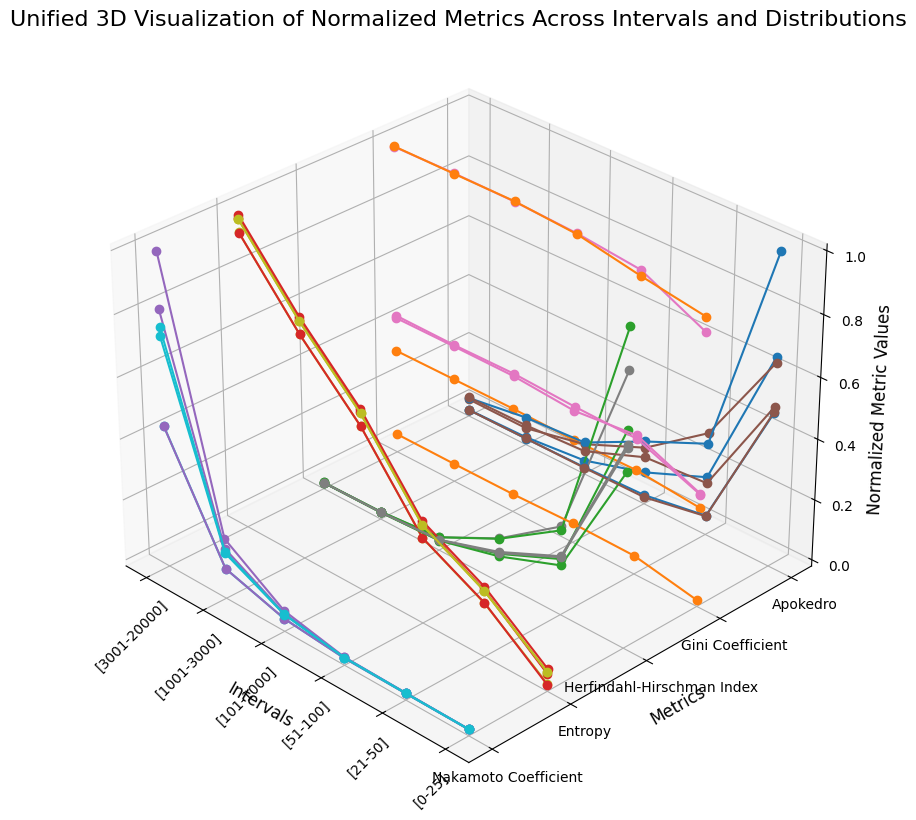

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

# Define metrics and intervals
metrics = ["Apokedro", "Gini Coefficient", "Herfindahl-Hirschman Index", "Entropy", "Nakamoto Coefficient"]
intervals = {
    "[0-25]": (0, 25),
    "[21-50]": (21, 50),
    "[51-100]": (51, 100),
    "[101-1000]": (101, 1000),
    "[1001-3000]": (1001, 3000),
    "[3001-20000]": (3001, 20000)
}

# Aggregate data for each interval
interval_results = []

for interval_name, (low, high) in intervals.items():
    df_subset = results_df[(results_df["Sample Length"] >= low) & (results_df["Sample Length"] <= high)]
    if not df_subset.empty:
        mean_table = df_subset.groupby("Distribution")[metrics].mean()
        mean_table["Interval"] = interval_name
        interval_results.append(mean_table)

# Combine all interval data
interval_results_df = pd.concat(interval_results).reset_index()

# Normalize the metric values
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(interval_results_df[metrics])
normalized_df = pd.DataFrame(
    normalized_metrics, columns=metrics, index=interval_results_df.index
)
normalized_df["Distribution"] = interval_results_df["Distribution"]
normalized_df["Interval"] = interval_results_df["Interval"]

# Unified 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Prepare mappings for categorical data
interval_names = normalized_df["Interval"].unique()
distributions = normalized_df["Distribution"].unique()
metric_map = {metric: i for i, metric in enumerate(metrics)}

interval_map = {name: i for i, name in enumerate(interval_names)}
distribution_map = {dist: i for i, dist in enumerate(distributions)}

# Plot each combination of metric and distribution
for dist in distributions:
    dist_data = normalized_df[normalized_df["Distribution"] == dist]
    for metric in metrics:
        x = dist_data["Interval"].map(interval_map)
        y = [metric_map[metric]] * len(dist_data)
        z = dist_data[metric]

        ax.plot(
            x, y, z, marker='o', linestyle='-', label=f"{dist}-{metric}"
        )

# Customize axes
ax.set_title("Unified 3D Visualization of Normalized Metrics Across Intervals and Distributions", fontsize=16)
ax.set_xlabel("Intervals", fontsize=12)
ax.set_ylabel("Metrics", fontsize=12)
ax.set_zlabel("Normalized Metric Values", fontsize=12)

ax.set_xticks(list(interval_map.values()))
ax.set_xticklabels(interval_map.keys(), rotation=45)
ax.set_yticks(list(metric_map.values()))
ax.set_yticklabels(metric_map.keys())

# Adjust the view angle
ax.view_init(elev=30, azim=135)

plt.tight_layout()
plt.show()

In [14]:
print(results_df.columns)

Index(['Distribution', 'Sample Length', 'Gini Coefficient',
       'Herfindahl-Hirschman Index', 'Entropy', 'Nakamoto Coefficient',
       'Apokedro'],
      dtype='object')


Mean Values of Metrics Across Different Distributions:
              Apokedro  Gini Coefficient  Herfindahl-Hirschman Index  \
Distribution                                                           
Bimodal       0.016494          0.227844                    0.006155   
Chi-Square    0.030713          0.497637                    0.009242   
Exponential   0.034153          0.498166                    0.009727   
Log-normal    0.024689          0.274561                    0.006262   
Normal        0.009898          0.112044                    0.005227   
Uniform       0.009379          0.271200                    0.006059   

               Entropy  Nakamoto Coefficient  
Distribution                                  
Bimodal       6.615133           1332.423913  
Chi-Square    6.285253            723.330745  
Exponential   6.284315            722.138199  
Log-normal    6.581928           1194.266304  
Normal        6.685580           1631.350932  
Uniform       6.585525           1243.8

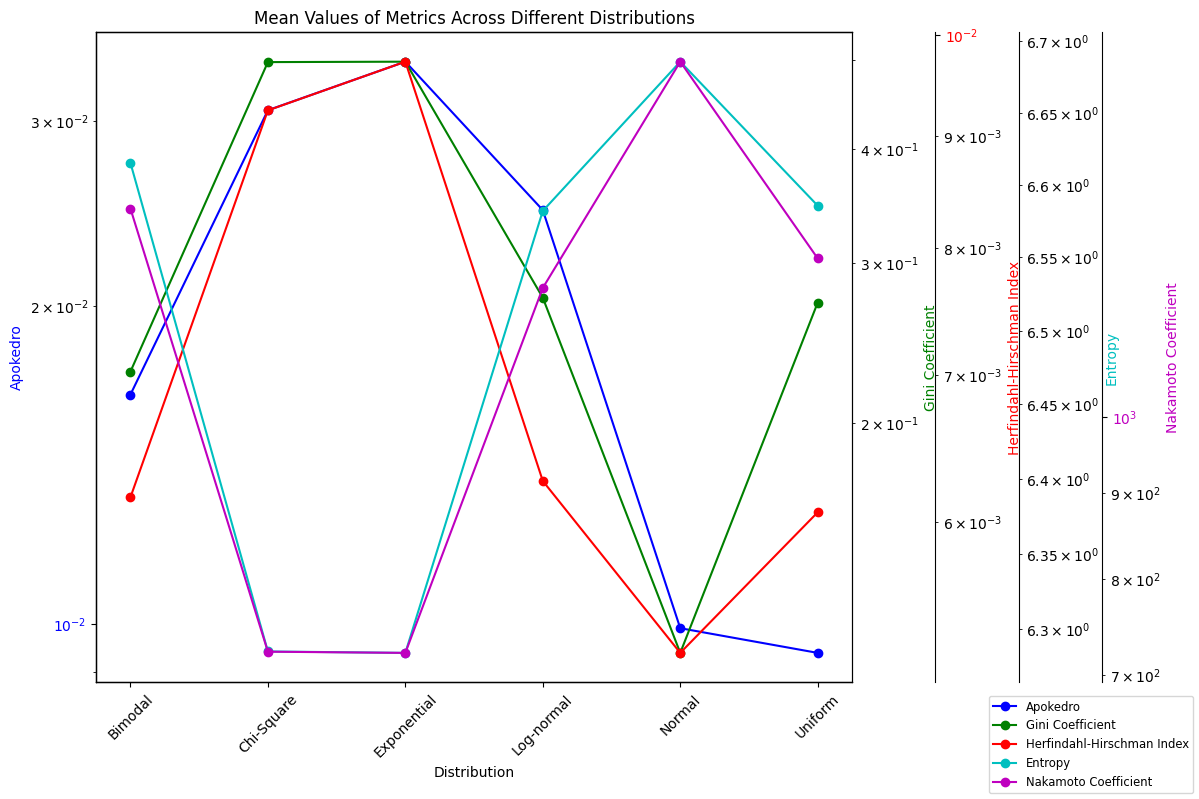

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_df is already available with the necessary data

# Metrics to plot
metrics = ["Apokedro", "Gini Coefficient", "Herfindahl-Hirschman Index", "Entropy", "Nakamoto Coefficient"]
colors = ['b', 'g', 'r', 'c', 'm']

# Calculate mean values for each distribution and each metric
mean_values = results_df.groupby('Distribution')[metrics].mean()

# Display the table
print("Mean Values of Metrics Across Different Distributions:")
print(mean_values)

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 8))

x = range(len(mean_values.index))  # x positions for each distribution

# Primary axis for Apokedro
line, = ax1.plot(x, mean_values["Apokedro"], marker='o', linestyle='-', color=colors[0], label="Apokedro")
ax1.set_ylabel("Apokedro", color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.set_yscale('log')
ax1.set_xlabel('Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels(mean_values.index, rotation=45)

# Additional axes for other metrics
axes = [ax1]
lines = [line]
labels = ["Apokedro"]

for i in range(1, len(metrics)):
    ax = ax1.twinx()
    if i > 1:
        ax.spines['right'].set_position(('outward', 60 * (i - 1)))
    axes.append(ax)
    line, = ax.plot(x, mean_values[metrics[i]], marker='o', linestyle='-', color=colors[i], label=metrics[i])
    ax.set_ylabel(metrics[i], color=colors[i])
    ax.tick_params(axis='y', labelcolor=colors[i])
    ax.set_yscale('log')
    lines.append(line)
    labels.append(metrics[i])

ax1.set_title('Mean Values of Metrics Across Different Distributions')

# Create a single combined legend
fig.legend(lines, labels, loc='lower right', fontsize='small')

fig.tight_layout()
plt.show()

# Save the mean values table to a CSV file
mean_values.to_csv('mean_values_of_metrics_across_distributions.csv', index=True)


Correlation between 'Sample Length' and each coefficient:
Gini Coefficient: 0.004801738000506835
Herfindahl-Hirschman Index: -0.11942496557867976
Entropy: 0.8296637048836808
Nakamoto Coefficient: 0.9515437810896371
Apokedro: -0.09789157617097233

Processing coefficient: Gini Coefficient

Regression results for Gini Coefficient:

                            OLS Regression Results                            
Dep. Variable:       Gini Coefficient   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.149e+05
Date:                Mon, 06 Jan 2025   Prob (F-statistic):               0.00
Time:                        22:29:09   Log-Likelihood:                 21533.
No. Observations:                7728   AIC:                        -4.305e+04
Df Residuals:                    7721   BIC:                        -4.300e+04
Df Model:                           6

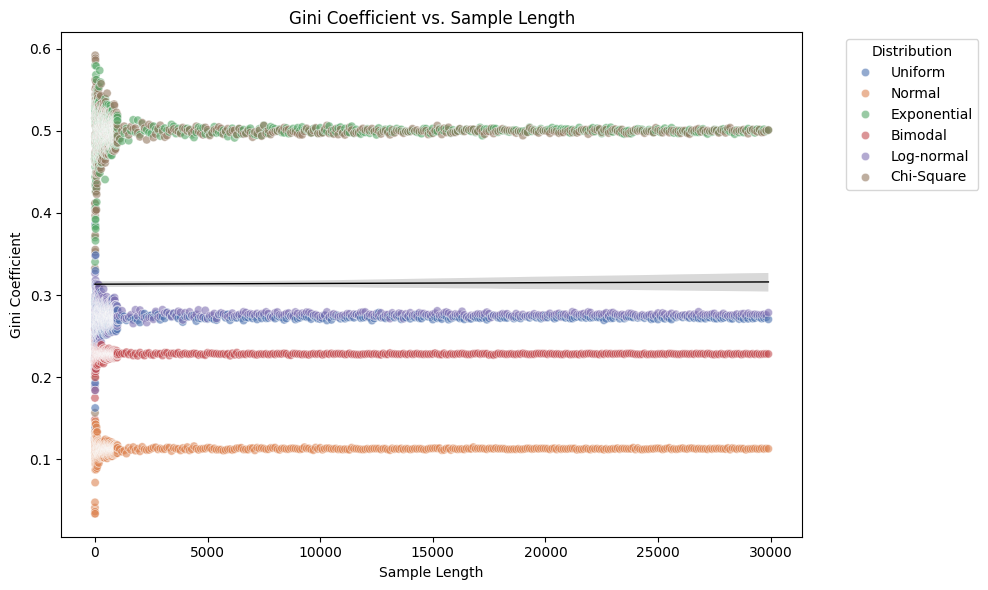

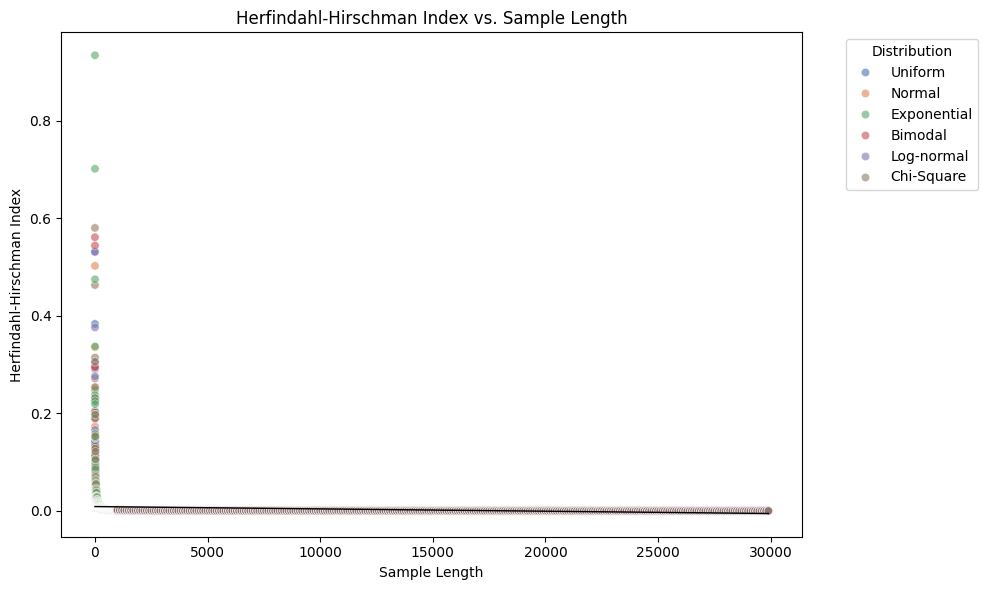

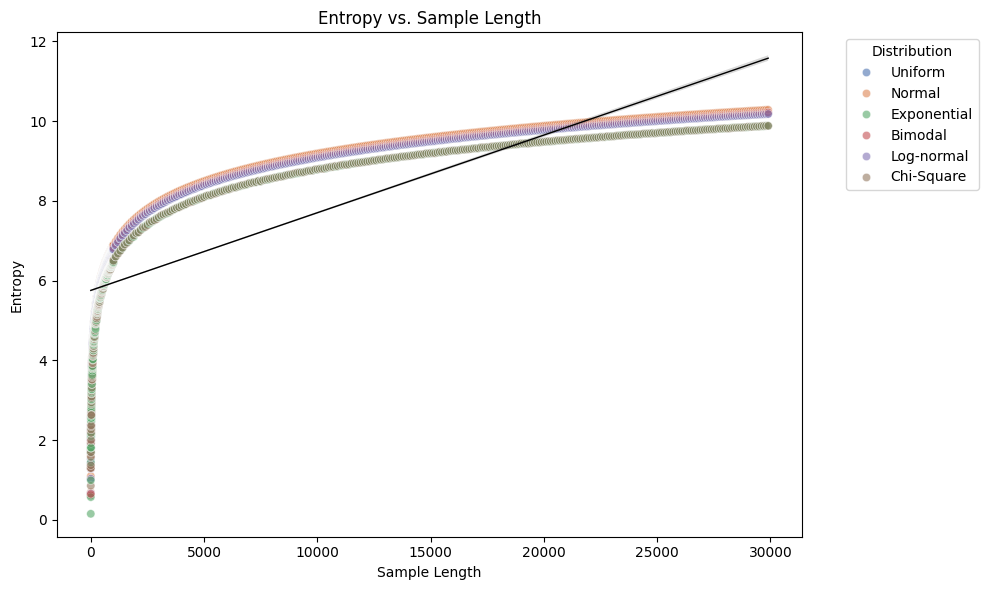

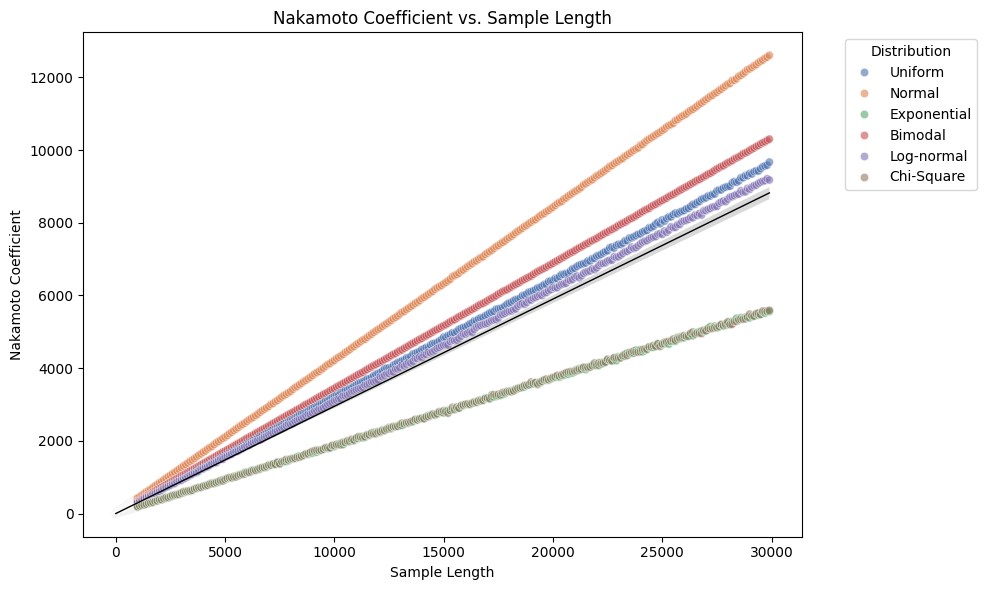

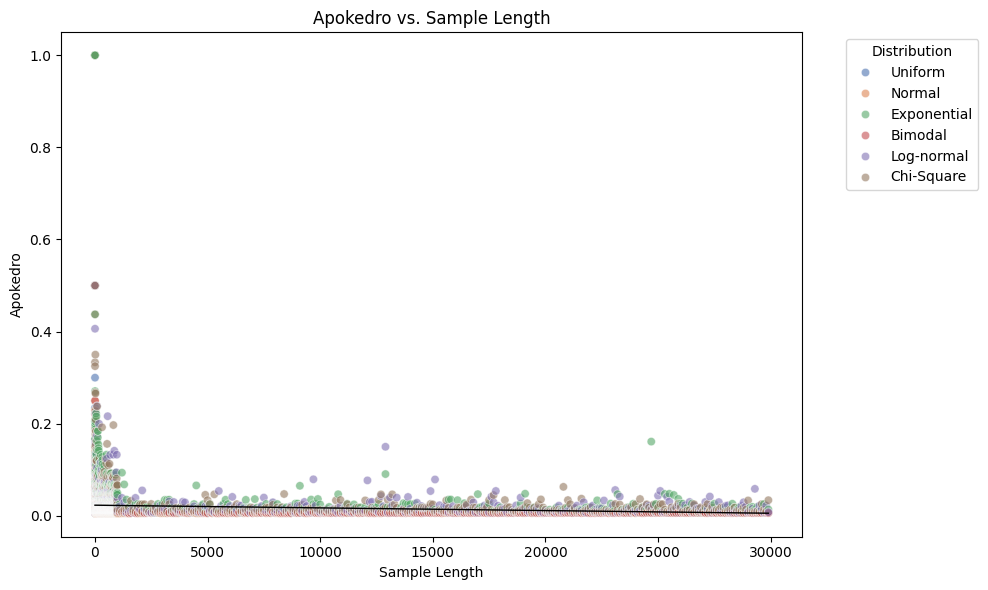

/var/folders/p1/p3sbndqd5_b5_mpf25c8v5r40000gn/T/ipykernel_77389/1032085070.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Distribution', y=coef, palette='pastel')


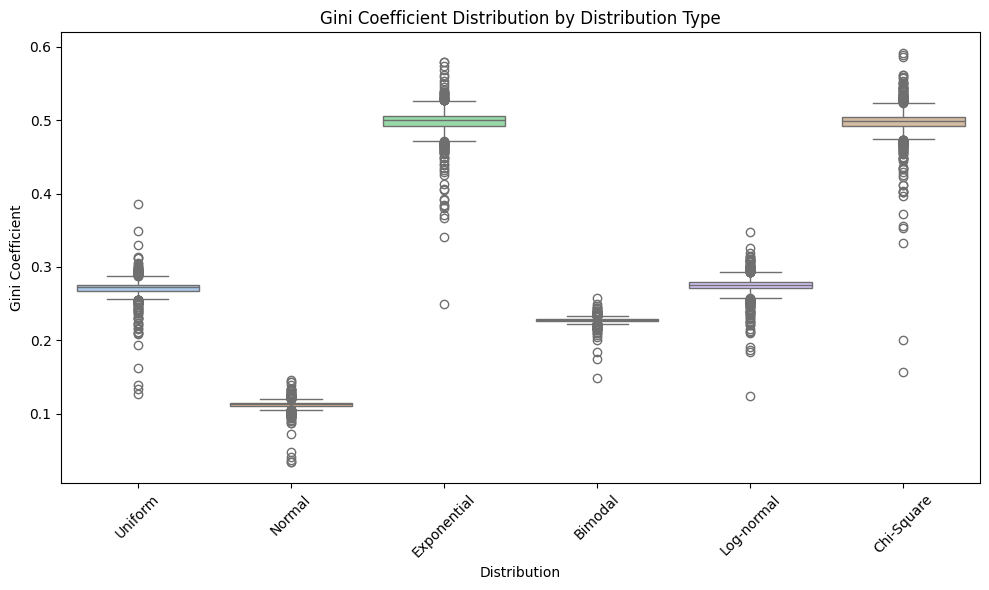

/var/folders/p1/p3sbndqd5_b5_mpf25c8v5r40000gn/T/ipykernel_77389/1032085070.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Distribution', y=coef, palette='pastel')


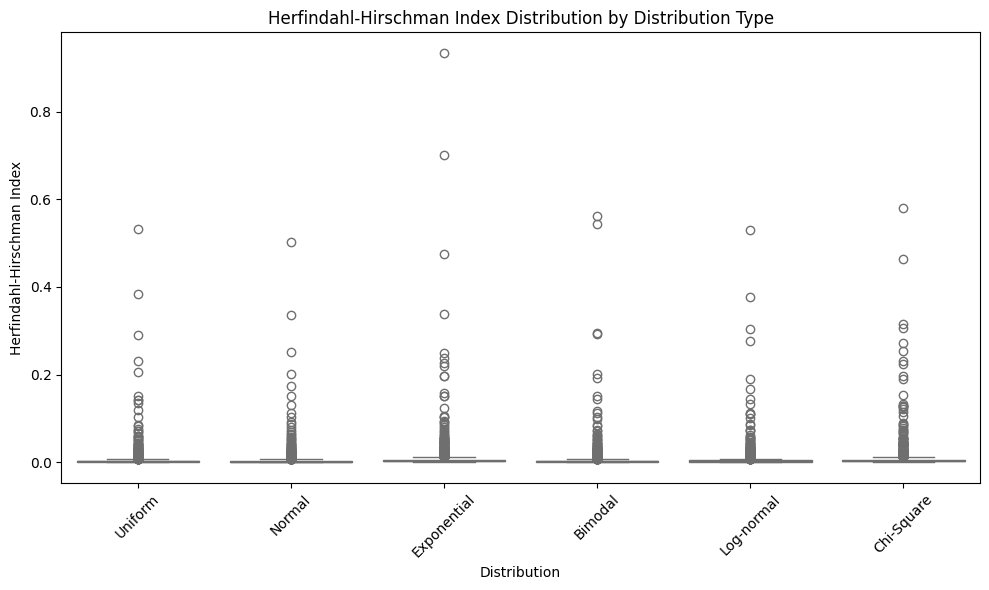

/var/folders/p1/p3sbndqd5_b5_mpf25c8v5r40000gn/T/ipykernel_77389/1032085070.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Distribution', y=coef, palette='pastel')


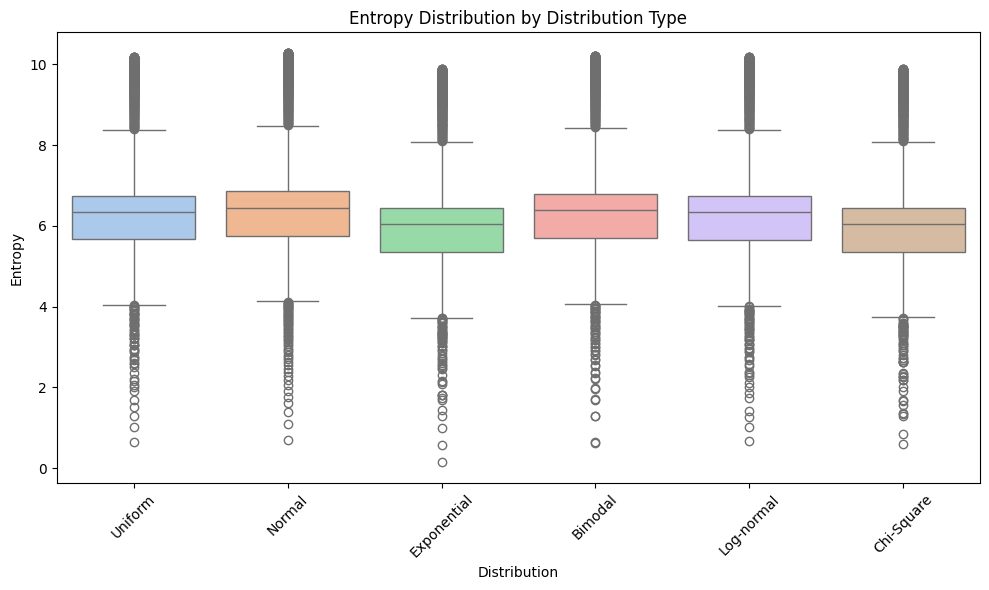

/var/folders/p1/p3sbndqd5_b5_mpf25c8v5r40000gn/T/ipykernel_77389/1032085070.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Distribution', y=coef, palette='pastel')


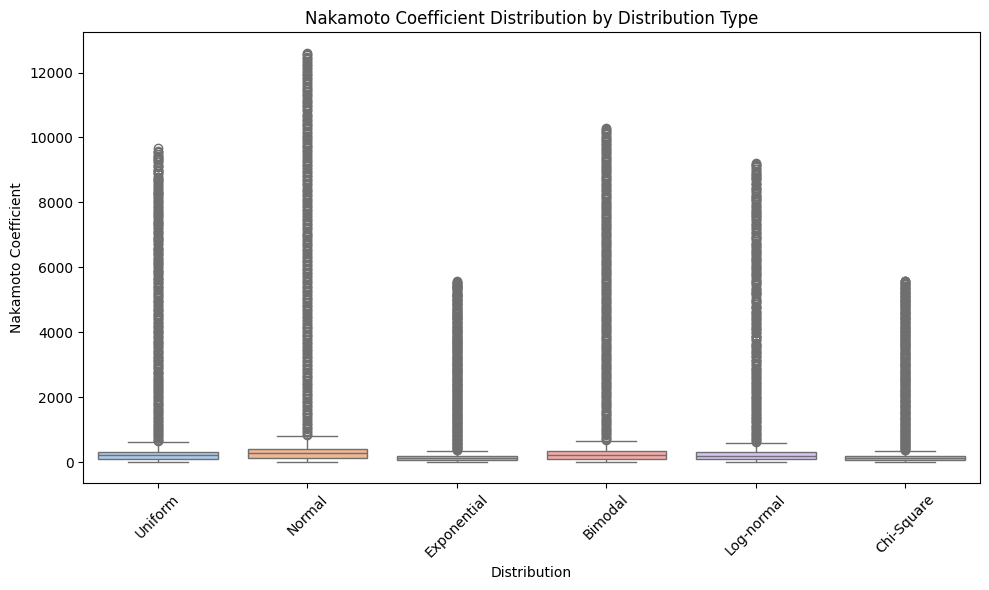

/var/folders/p1/p3sbndqd5_b5_mpf25c8v5r40000gn/T/ipykernel_77389/1032085070.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Distribution', y=coef, palette='pastel')


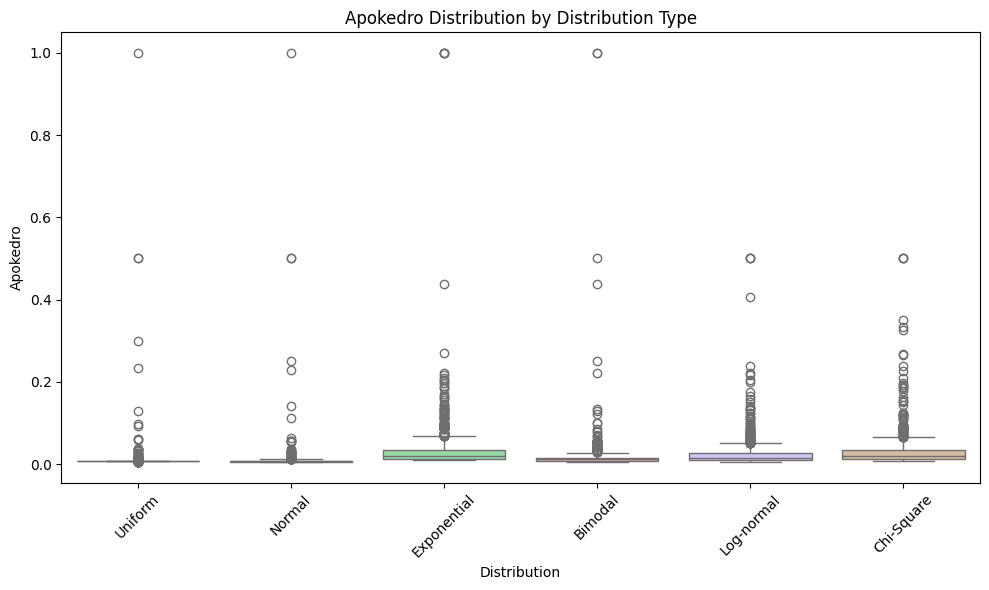

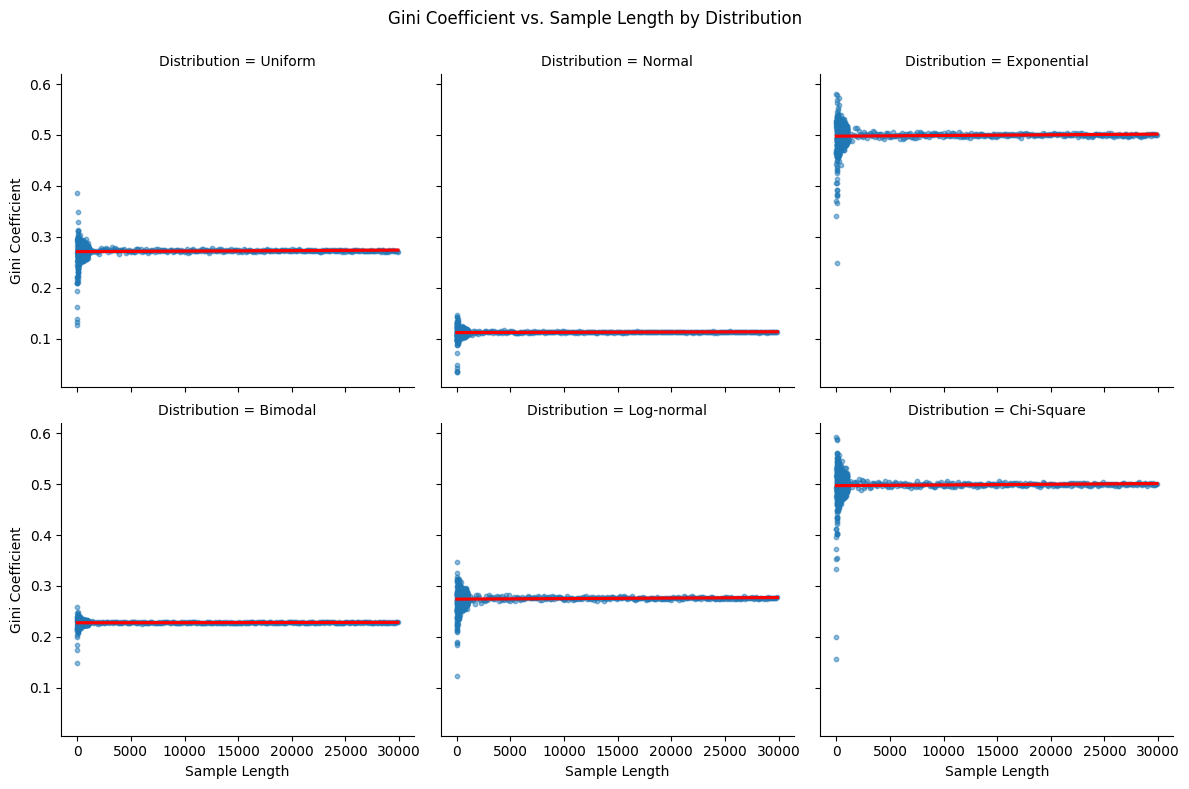

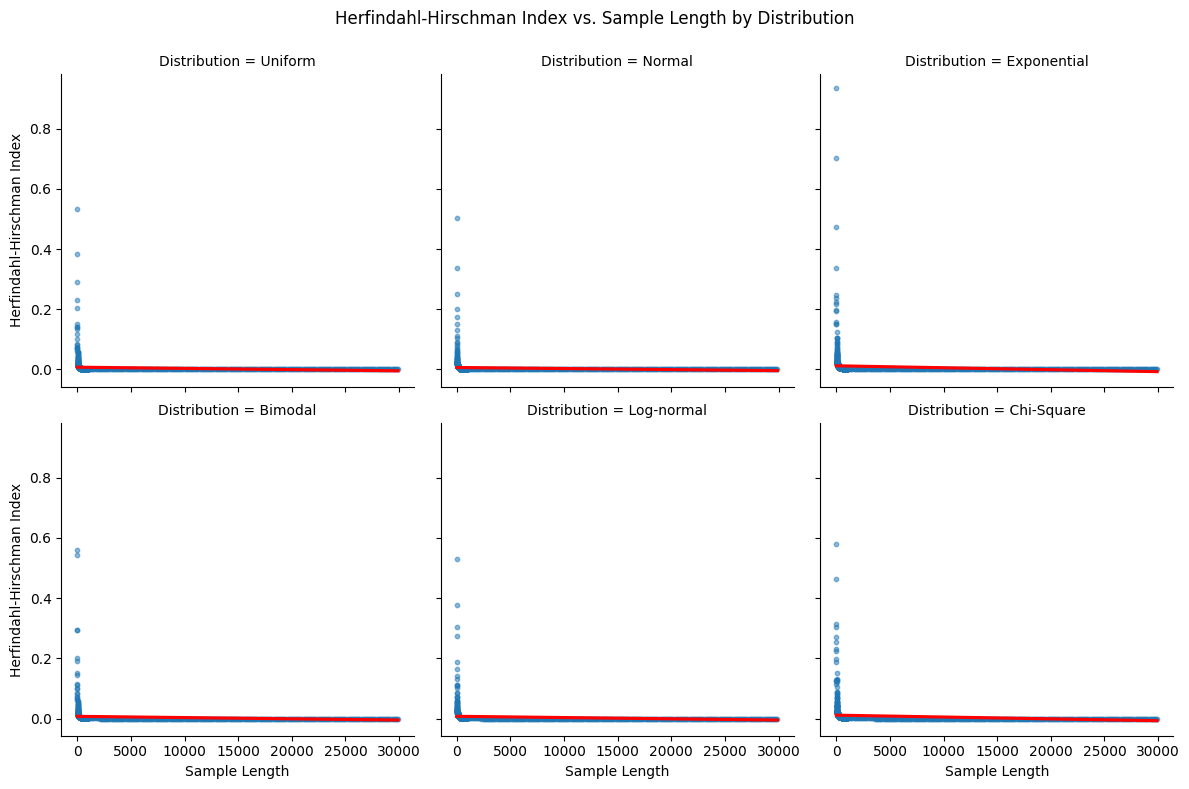

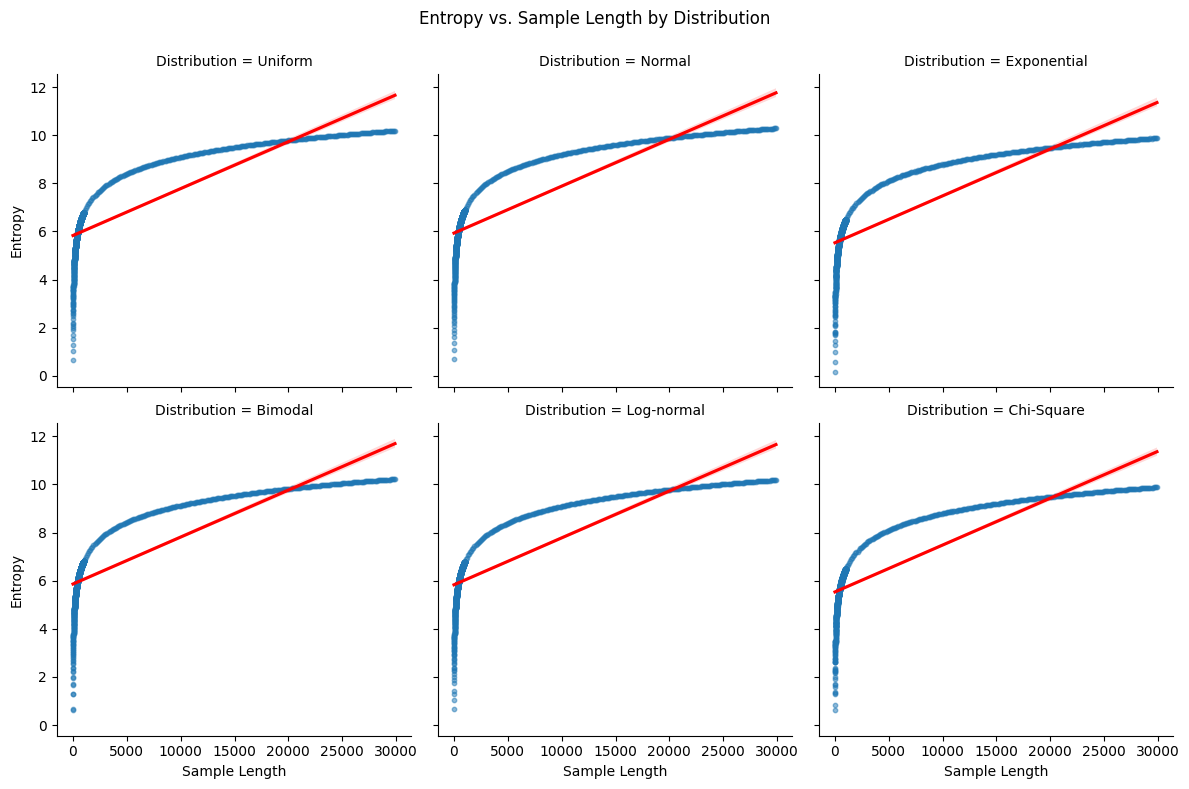

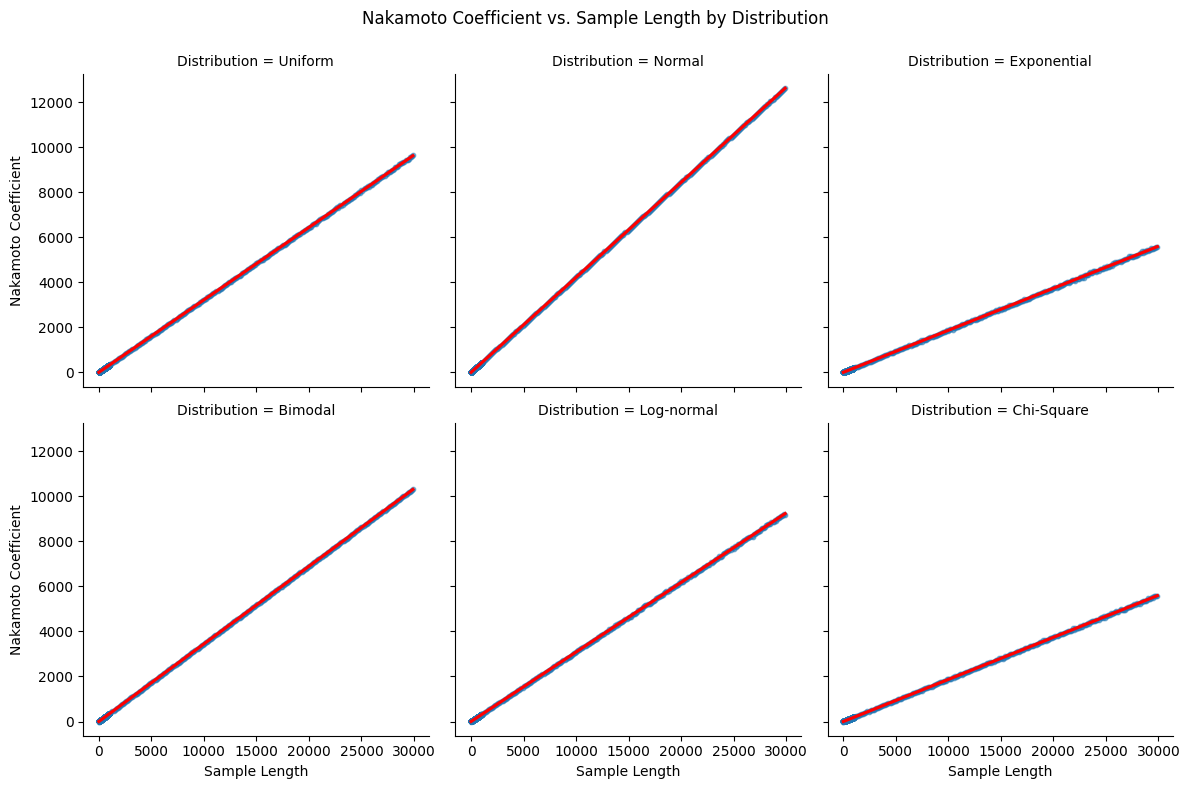

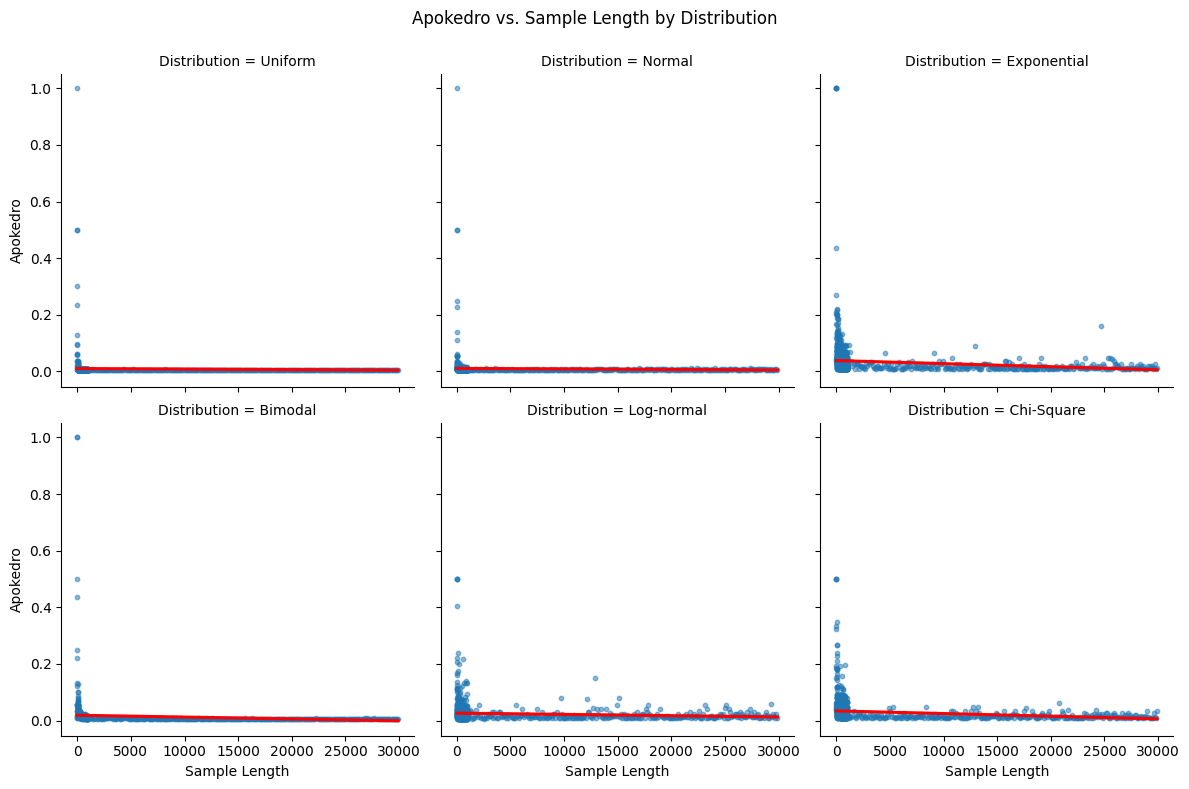

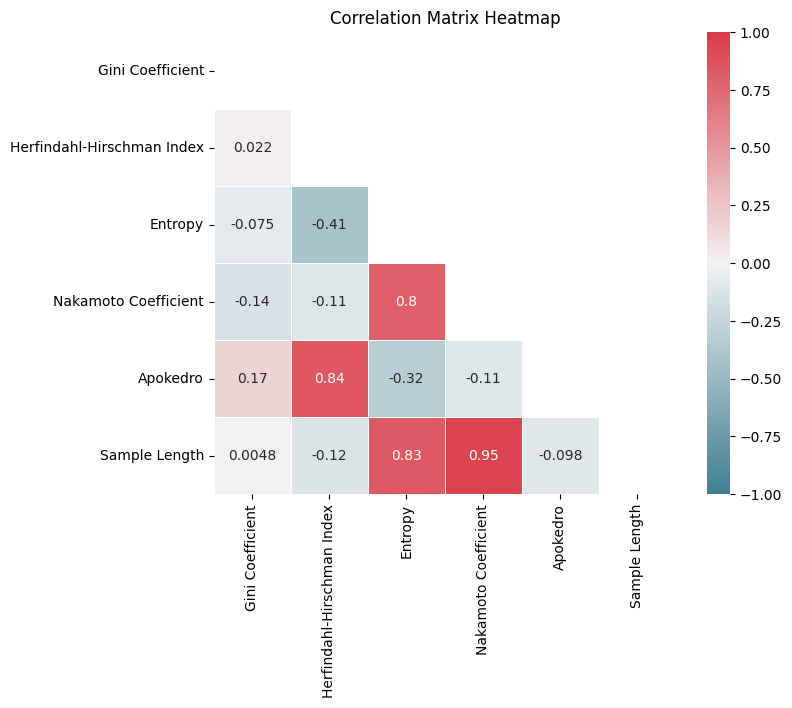

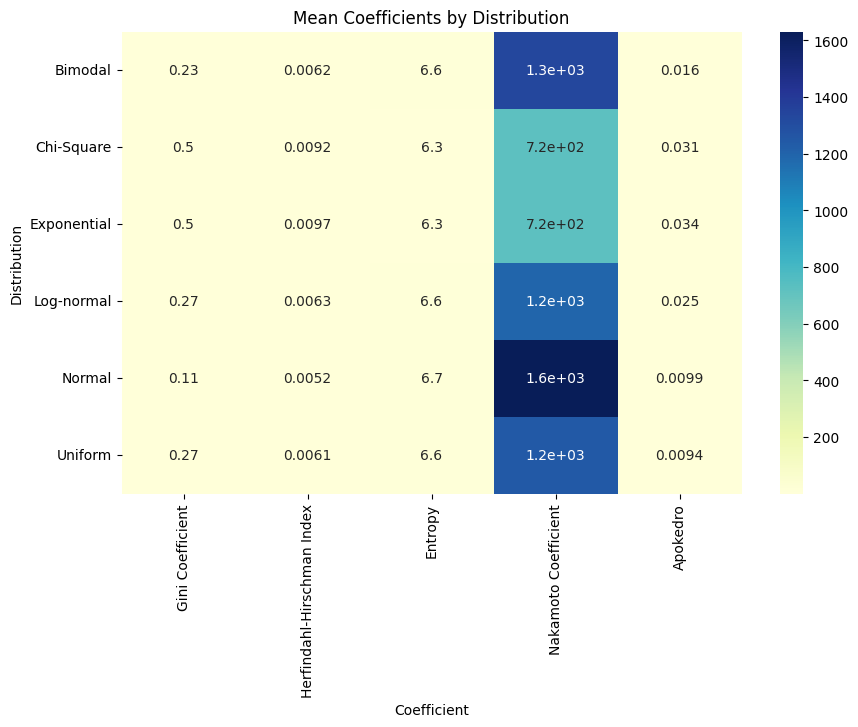


Residual Plot for Gini Coefficient


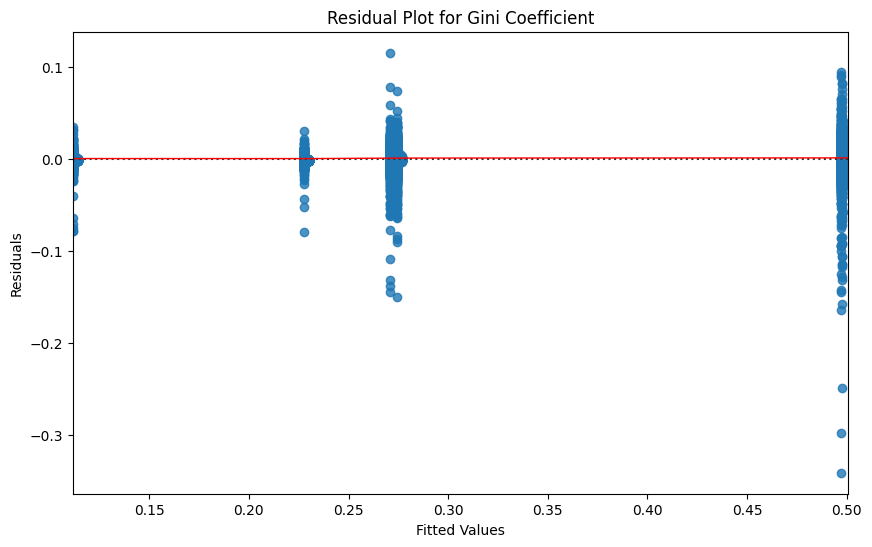


Residual Plot for Herfindahl-Hirschman Index


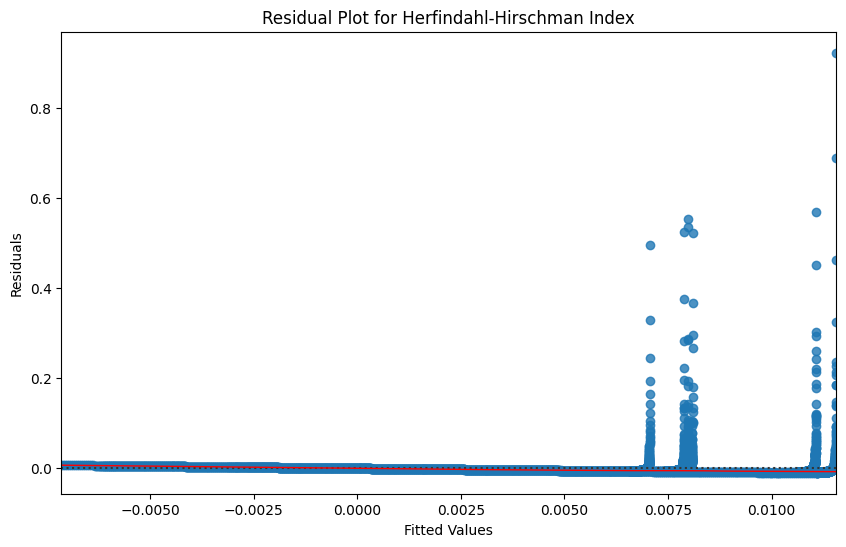


Residual Plot for Entropy


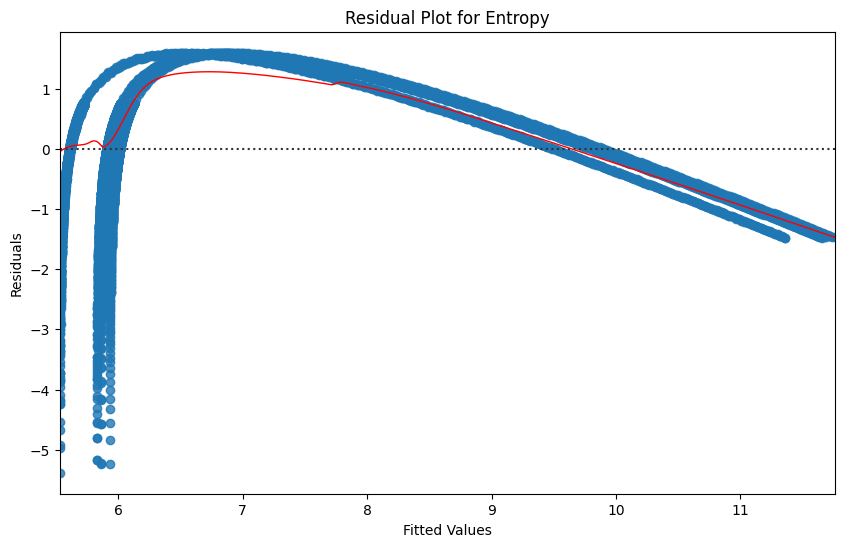


Residual Plot for Nakamoto Coefficient


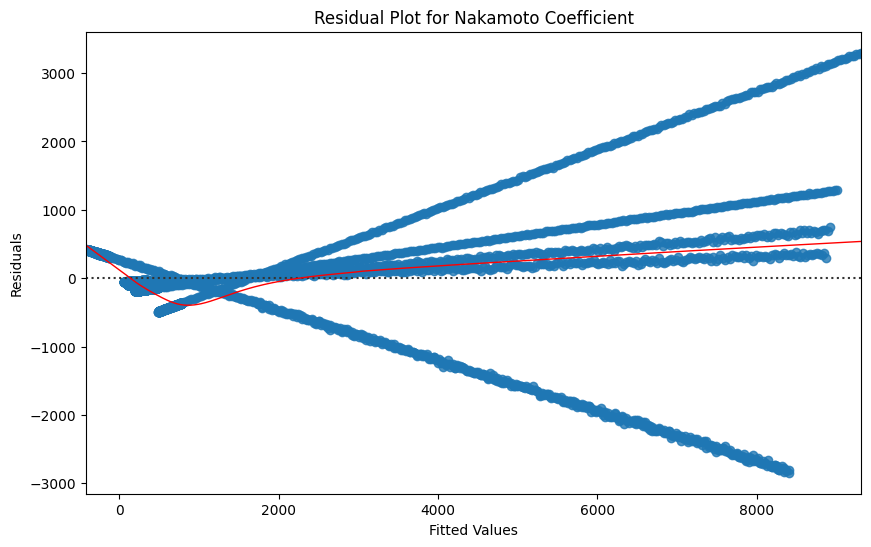


Residual Plot for Apokedro


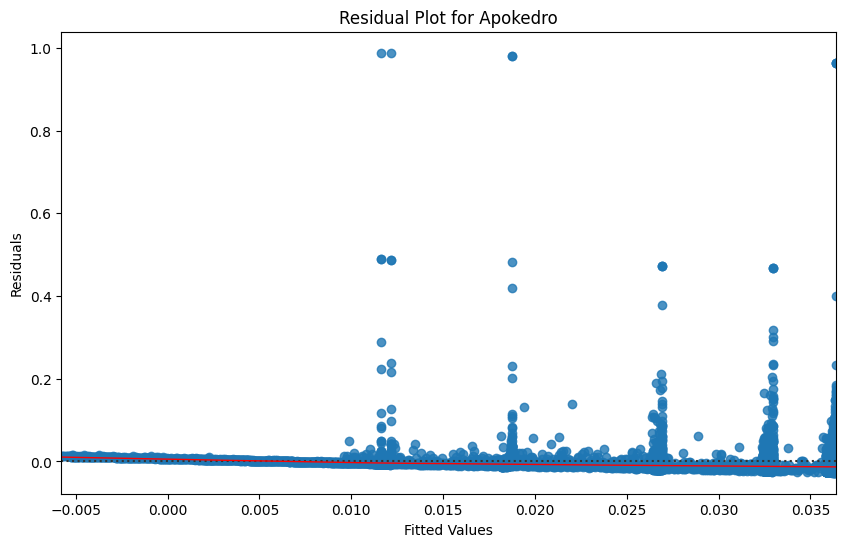

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Ensure plots display within the notebook
%matplotlib inline

# -----------------------------
# 1. Data Loading and Preparation
# -----------------------------

# Load your data into 'results_df'
# Uncomment and adjust the following line if needed:
# results_df = pd.read_csv('experiment_results_2.csv')

# For the purpose of this code, ensure that 'results_df' is already loaded.

# Ensure 'Sample Length' is numeric
results_df['Sample Length'] = pd.to_numeric(results_df['Sample Length'], errors='coerce')

# Define the list of coefficients
coefficients = ['Gini Coefficient', 'Herfindahl-Hirschman Index', 'Entropy', 'Nakamoto Coefficient', 'Apokedro']

# Drop rows with missing values in 'Sample Length' or coefficients
results_df = results_df.dropna(subset=['Sample Length'] + coefficients)

# -----------------------------
# 2. Correlation Analysis
# -----------------------------

print("Correlation between 'Sample Length' and each coefficient:")
for coef in coefficients:
    corr = results_df['Sample Length'].corr(results_df[coef])
    print(f"{coef}: {corr}")

# -----------------------------
# 3. Regression Analysis for Each Coefficient
# -----------------------------

# One-hot encode 'Distribution' without dropping any categories
results_encoded = pd.get_dummies(results_df, columns=['Distribution'], drop_first=False)

# Define independent variables (Sample Length and Distribution types)
distribution_cols = [col for col in results_encoded.columns if col.startswith('Distribution_')]
X_base = results_encoded[['Sample Length'] + distribution_cols]

for coef in coefficients:
    print(f"\nProcessing coefficient: {coef}")
    y = results_df[coef]
    X = X_base.copy()
    
    # Convert X and y to numeric types
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    # Combine X and y into a single DataFrame
    data = pd.concat([X, y], axis=1)
    
    # Drop rows with any missing values
    data_clean = data.dropna()
    
    # Separate X_clean and y_clean after cleaning
    y_clean = data_clean[coef]
    X_clean = data_clean.drop(columns=[coef])
    
    # Ensure all data in X_clean and y_clean is numeric
    X_clean = X_clean.astype(float)
    y_clean = y_clean.astype(float)
    
    # Add constant term
    X_clean = sm.add_constant(X_clean)
    
    # Fit the regression model
    model = sm.OLS(y_clean, X_clean).fit()
    print(f"\nRegression results for {coef}:\n")
    print(model.summary())

# -----------------------------
# 4. Visualization
# -----------------------------

# Scatter plots with regression lines for each coefficient
for coef in coefficients:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='Sample Length', y=coef, hue='Distribution', palette='deep', alpha=0.6)
    sns.regplot(data=results_df, x='Sample Length', y=coef, scatter=False, color='black', line_kws={'linewidth':1})
    plt.title(f'{coef} vs. Sample Length')
    plt.xlabel('Sample Length')
    plt.ylabel(coef)
    plt.legend(title='Distribution', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Box plots of each coefficient by Distribution
for coef in coefficients:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=results_df, x='Distribution', y=coef, palette='pastel')
    plt.title(f'{coef} Distribution by Distribution Type')
    plt.xlabel('Distribution')
    plt.ylabel(coef)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Faceted regression plots by Distribution
for coef in coefficients:
    g = sns.lmplot(
        data=results_df,
        x='Sample Length',
        y=coef,
        col='Distribution',
        col_wrap=3,
        height=4,
        scatter_kws={'alpha':0.5, 's':10},
        line_kws={'color':'red'}
    )
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'{coef} vs. Sample Length by Distribution')
    plt.show()

# Heatmap of correlation matrix
corr_matrix = results_df[coefficients + ['Sample Length']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, annot=True, vmax=1, vmin=-1, center=0, square=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Heatmap of mean coefficients by Distribution
mean_coefficients = results_df.groupby('Distribution')[coefficients].mean()
plt.figure(figsize=(10, 6))
sns.heatmap(mean_coefficients, annot=True, cmap='YlGnBu')
plt.title('Mean Coefficients by Distribution')
plt.xlabel('Coefficient')
plt.ylabel('Distribution')
plt.show()

# Residual plots for each coefficient
# Center Sample Length for interpretability
results_df['Sample_Length_Centered'] = results_df['Sample Length'] - results_df['Sample Length'].mean()

for coef in coefficients:
    formula = f'Q("{coef}") ~ Sample_Length_Centered + C(Distribution)'
    model = smf.ols(formula=formula, data=results_df).fit()
    print(f'\nResidual Plot for {coef}')
    plt.figure(figsize=(10, 6))
    sns.residplot(
        x=model.fittedvalues,
        y=model.resid,
        lowess=True,
        line_kws={'color': 'red', 'lw': 1}
    )
    plt.title(f'Residual Plot for {coef}')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.show()

In [14]:
# One-hot encode 'Distribution' and drop the first category to avoid multicollinearity
results_encoded = pd.get_dummies(results_df, columns=['Distribution'], drop_first=True)

# Define independent variables (Sample Length and adjusted Distribution types)
distribution_cols = [col for col in results_encoded.columns if col.startswith('Distribution_')]
X_base = results_encoded[['Sample Length'] + distribution_cols]

# For each coefficient, perform regression analysis
for coef in coefficients:
    print(f"\nProcessing coefficient: {coef}")
    y = results_df[coef]
    X = X_base.copy()
    
    # Convert X and y to numeric types
    X = X.apply(pd.to_numeric, errors='coerce')
    y = pd.to_numeric(y, errors='coerce')
    
    # Combine X and y into a single DataFrame
    data = pd.concat([X, y], axis=1)
    
    # Drop rows with any missing values
    data_clean = data.dropna()
    
    # Separate X_clean and y_clean after cleaning
    y_clean = data_clean[coef]
    X_clean = data_clean.drop(columns=[coef])
    
    # Ensure all data in X_clean and y_clean is numeric
    X_clean = X_clean.astype(float)
    y_clean = y_clean.astype(float)
    
    # Add constant term
    X_clean = sm.add_constant(X_clean)
    
    # Fit the regression model
    model = sm.OLS(y_clean, X_clean).fit()
    print(f"\nRegression results for {coef}:\n")
    print(model.summary())


Processing coefficient: Gini Coefficient

Regression results for Gini Coefficient:

                            OLS Regression Results                            
Dep. Variable:       Gini Coefficient   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 7.743e+04
Date:                Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                        11:04:58   Log-Likelihood:                 18567.
No. Observations:                7009   AIC:                        -3.712e+04
Df Residuals:                    7002   BIC:                        -3.707e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------


Processing coefficient: Gini Coefficient

OLS Regression results for Gini Coefficient:

                              OLS Regression Results                             
Dep. Variable:     Q("Gini Coefficient")   R-squared:                       0.985
Model:                               OLS   Adj. R-squared:                  0.985
Method:                    Least Squares   F-statistic:                 7.743e+04
Date:                   Wed, 18 Sep 2024   Prob (F-statistic):               0.00
Time:                           11:19:35   Log-Likelihood:                 18567.
No. Observations:                   7009   AIC:                        -3.712e+04
Df Residuals:                       7002   BIC:                        -3.707e+04
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025     

/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3663: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred)
/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3470: RuntimeWarning: overflow encountered in multiply
  dparams = exog*a1 * (y-mu)/(mu+a1)
/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:3470: RuntimeWarning: invalid value encountered in multiply
  dparams = exog*a1 * (y-mu)/(mu+a1)
/Users/manos/Documents/Code/Decentralization metric/APOKEDRO/venv/lib/python3.12/site-p

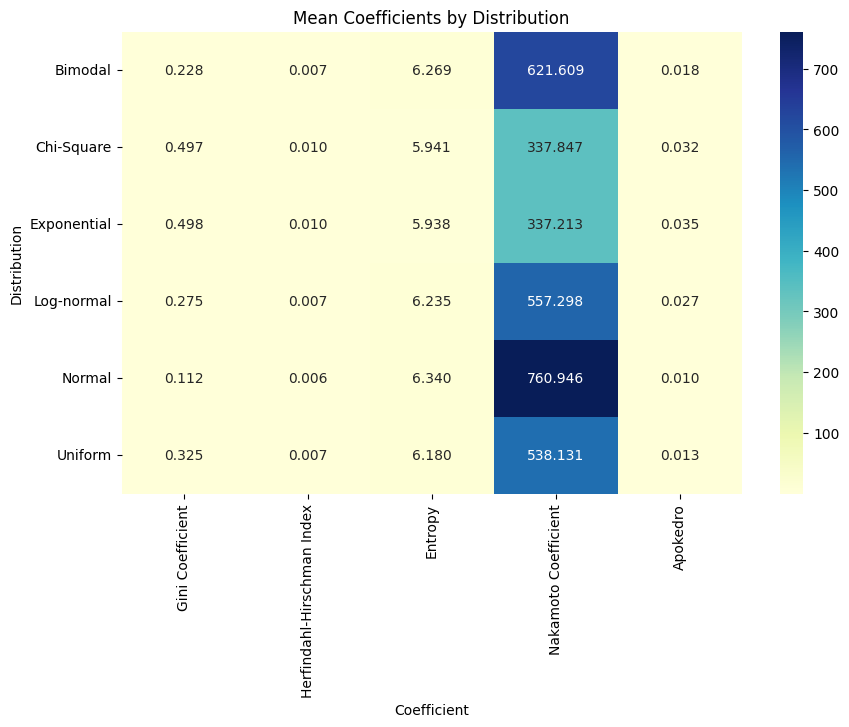

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Ensure plots display within the notebook
%matplotlib inline

# -----------------------------
# 1. Data Loading and Preparation
# -----------------------------

# Load your data into 'results_df'
# Uncomment and adjust the following line if needed:
# results_df = pd.read_csv('your_data_file.csv')

# Ensure 'Sample Length' is numeric
results_df['Sample Length'] = pd.to_numeric(results_df['Sample Length'], errors='coerce')

# Define the list of coefficients
coefficients = ['Gini Coefficient', 'Herfindahl-Hirschman Index', 'Entropy', 'Nakamoto Coefficient', 'Apokedro']

# Drop rows with missing values in 'Sample Length' or coefficients
results_df = results_df.dropna(subset=['Sample Length'] + coefficients)

# Ensure 'Distribution' is a categorical variable
results_df['Distribution'] = results_df['Distribution'].astype('category')

# Center 'Sample Length' for interpretability (optional)
results_df['Sample_Length_Centered'] = results_df['Sample Length'] - results_df['Sample Length'].mean()

# -----------------------------
# 2. Regression Analysis
# -----------------------------

# For each coefficient, perform regression analysis
for coef in coefficients:
    print(f"\nProcessing coefficient: {coef}")
    
    # Specify the formula
    if coef == 'Nakamoto Coefficient':
        # For count data, use Negative Binomial regression
        formula = f'Q("{coef}") ~ Sample_Length_Centered + C(Distribution)'
        model = smf.negativebinomial(formula=formula, data=results_df).fit()
        print(f"\nNegative Binomial Regression results for {coef}:\n")
    else:
        # For other coefficients, use OLS regression
        formula = f'Q("{coef}") ~ Sample_Length_Centered + C(Distribution)'
        model = smf.ols(formula=formula, data=results_df).fit()
        print(f"\nOLS Regression results for {coef}:\n")
    
    # Print the regression summary
    print(model.summary())

# -----------------------------
# 3. Calculate Mean Coefficients by Distribution
# -----------------------------

# Calculate mean coefficients per distribution
mean_coefficients = results_df.groupby('Distribution')[coefficients].mean()

# -----------------------------
# 4. Generate Heatmap
# -----------------------------

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(mean_coefficients, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Mean Coefficients by Distribution')
plt.xlabel('Coefficient')
plt.ylabel('Distribution')
plt.show()